In [61]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



max_length = 16
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
def predict_step(image_paths):
  images = []
  for image_path in image_paths:
    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
      i_image = i_image.convert(mode="RGB")

    images.append(i_image)

  pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
  pixel_values = pixel_values.to(device)

  output_ids = model.generate(pixel_values, **gen_kwargs)

  preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
  preds = [pred.strip() for pred in preds]
  return preds

In [2]:
image_path = "./test_images/airport.jpg"
image = Image.open(image_path)
image = image.convert(mode="RGB")

pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values
pixel_values = pixel_values.to(device)

In [3]:
output_ids = model.generate(pixel_values, **gen_kwargs)


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


In [4]:

def top_k_sample(top_k_logits, temperature=1.0):
    """
    Perform top-k sampling with temperature on the top-k logits.

    Parameters:
    - top_k_logits: A 1D numpy array representing the top-k logits.
    - temperature: A parameter controlling the level of randomness in sampling.

    Returns:
    - A sampled index.
    """

    # Apply temperature to the logits
    logits_with_temperature = top_k_logits / temperature

    # Compute softmax to get probabilities
    probabilities = np.exp(logits_with_temperature - np.max(logits_with_temperature))
    probabilities /= np.sum(probabilities)

    # Sample from the top-k probabilities
    sampled_index = np.random.choice(np.arange(len(top_k_logits)), p=probabilities)

    return sampled_index


In [ ]:
def beam_search(input_ids, pixel_values, model_fn, stop_token_id=None, beam_width=5, max_len=50, temperature=1.0, look_back_length=5):
    """
    Performs beam search sampling on an LLM, with early stopping on encountering a specific token ID.

    Args:
        input_ids: List of integer IDs for the initial input sequence.
        pixel_values: (Optional) Pixel values to incorporate into the model prediction.
        model_fn: Function that takes input_ids, pixel_values (if provided), and returns logits for next token.
        stop_token_id: Integer ID of the token that triggers early stopping (optional).
        beam_width: Number of beams to keep at each step.
        max_len: Maximum length of the generated sequence.
        temperature: Controls the exploration-exploitation trade-off.

    Returns:
        best_sequence: List of integer IDs for the best generated sequence.
        best_score: Score of the best generated sequence.
        attention_weights: (Optional) List of attention weights for each step, if supported by the model.
    """

    # Initialize beams
    breams = [(input_ids, 1)]
    


    beams = [(input_ids, 0.0, [])]
    attention_weights = []

    # Iterate until max_len reached or all beams have finished
    for _ in tqdm(range(max_len)):
        all_beams = []
        for beam_idx, (current_ids, score, attention_weights_step) in enumerate(beams):

            # Check if all sequences have already stopped
            if all(next_id == stop_token_id for next_id in current_ids):
                continue

            # Get logits for next token
            logits, attention_weights_outputs = model_fn(current_ids, pixel_values)

            # Early stopping check
            if stop_token_id is not None and stop_token_id in logits:
                best_sequence = current_ids + [stop_token_id]
                best_score = score - np.log(logits[stop_token_id])
                return best_sequence, best_score, attention_weights

            # Update attention weights
            attention_weights.extend(attention_weights_outputs)

            # Apply temperature
            if temperature > 0:
                probs = np.exp(logits / temperature) / np.sum(np.exp(logits / temperature))
            else:
                probs = logits

            # Expand each beam
            topk = torch.topk(torch.tensor(probs), beam_width)
            top_k_probs, top_k_indices = topk.values.numpy(), topk.indices.numpy()

            for k in range(beam_width):
                next_id = top_k_indices[k]
                next_score = score - np.log(top_k_probs[k])
                next_ids = current_ids + [next_id]
                next_attention_weights = attention_weights_step + [attention_weights_outputs]  # Update attention weights
                all_beams.append((next_ids, next_score, next_attention_weights))

        # Prune beams
        beams = sorted(all_beams, key=lambda x: x[1], reverse=True)[:beam_width]

    # Return best beam
    # best_sequence, best_score = beams[0]
    best_sequence, _, _ = beams[0]
        
    return best_sequence, attention_weights

In [19]:
input_start_token = tokenizer("Describe this image: <|endoftext|>", return_tensors='pt')
input_ids = input_start_token['input_ids'].to('cuda')
attention_mask = input_start_token['attention_mask'].to('cuda')

In [6]:
def topk_items_indices(array, k):
    # Get the indices of the top-k items
    indices = np.argpartition(array, -k)[-k:]
    # Get the top-k items
    items = array[indices]
    # Return as a tuple
    return items, indices

In [45]:
def model_function(input_ids, pixel_values):
    with torch.no_grad():
        outputs = model(pixel_values, torch.tensor([input_ids]).cuda(), output_attentions=True)
        cross_attention = outputs.cross_attentions
        encoder_attention = outputs.encoder_attentions
        decoder_attention = outputs.decoder_attentions
        logits = torch.squeeze(outputs.logits[-1, -1].cpu()).numpy()

    return logits, cross_attention[-1].cpu()

### Greedy

In [20]:
input_ids.cpu().numpy().tolist()[0]

[24564, 4892, 428, 2939, 25, 220, 50256]

In [46]:
sampled_ids = input_ids.cpu().numpy().tolist()[0]
start_length = len(sampled_ids)
max_length = 20
attention_weights = []

while len(sampled_ids) <= max_length+start_length:
    logits, attention = model_function(sampled_ids, pixel_values)
    probs = np.exp(logits) / np.sum(np.exp(logits))

    sampled_idx = np.argmax(probs)

    attention_weights.append(attention[-1])

    sampled_ids.append(sampled_idx)

    print(tokenizer.decode(sampled_ids), end='\r')

    if sampled_idx == 50256:
        break
    
    

In [26]:
tokenizer.decode(sampled_ids[7:])

'airport shuttle buses are parked on the tarmac <|endoftext|>'

In [257]:
sequence_length = 20
attention_weights = []

for i in range(sequence_length-1):
    with torch.no_grad():
        outputs = model(pixel_values, torch.tensor([sampled_ids]).cuda(), output_attentions=True)
        cross_attention = outputs.cross_attentions
        encoder_attention = outputs.encoder_attentions
        decoder_attention = outputs.decoder_attentions
        logits = torch.squeeze(outputs.logits.cpu()).numpy()


    attention_weights.append(cross_attention[-1].cpu())
    topk = torch.topk(torch.tensor(logits), k=500)
    if len(topk.values.shape) > 1:
        top_k_logits = topk.values.numpy()[0]
        top_k_indices = topk.indices.numpy()[0]
    else:
        top_k_logits = topk.values.numpy()
        top_k_indices = topk.indices.numpy()
    # top_k_logits, top_k_indices = topk_items_indices(logits, 500)
    sampled = top_k_indices[top_k_sample(top_k_logits, temperature=0.2)]

    sampled_ids.append(sampled)

    print(tokenizer.decode(sampled_ids), end='\r')

In [30]:
def attention_heat_map(attention_weights, image_size=224, patch_size=16):
    # Assuming attention_weights is your array of shape [12, 1, 197]
    # Reshape it to [12, 197]
    num_heads = attention_weights.shape[0]
    num_patches = attention_weights.shape[-1]

    attention_weights_reshaped = np.squeeze(attention_weights, axis=1)

    # The first patch is usually a [CLS] token in Vision Transformer, so we remove it
    attention_weights_reshaped = attention_weights_reshaped[:, 1:]

    # Now reshape it to [12, 14, 14] because sqrt(196) = 14
    num_patches_one_axis = np.sqrt(num_patches).astype(int)
    attention_weights_reshaped = attention_weights_reshaped.reshape((num_heads, num_patches_one_axis, num_patches_one_axis))

    # Upsample the 14x14 map to 224x224 for each head
    upsampled_maps = [np.kron(attention_weights_reshaped[i], np.ones((patch_size, patch_size))) for i in range(num_heads)]

    # Now upsampled_maps is a list of 12 attention maps of shape [224, 224]
    # You can average them
    average_map = np.mean(upsampled_maps, axis=0)

    return average_map

 shuttle


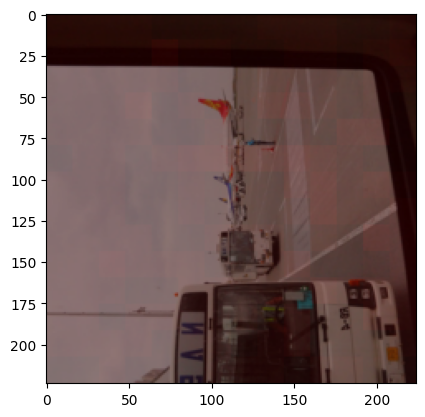

In [265]:
test_idx = 2
sampled = sampled_ids[7:]
token = sampled[test_idx]
print(tokenizer.decode(token))

test = attention_weights[test_idx]
average_attention = attention_heat_map(test[:, -1, :])
colormap = plt.get_cmap('hot')
heatmap = (colormap(average_attention) * 2**2)[:,:,:3]

heatmap_image = Image.fromarray((heatmap).astype(np.uint8))
image_pixels = pixel_values[0].cpu().numpy()
image_array = image_pixels.T
image_array = (((image_array + 1)/2)*255).astype(np.uint8)
base_image = Image.fromarray(image_array)
plt.imshow(cv2.addWeighted((heatmap*255).astype(int), 0.5, image_array.astype(int), 0.5, 0))


In [270]:
average_attention = attention_heat_map(test[:, -1, :])
colormap = plt.get_cmap('hot')
heatmap = (colormap(average_attention))

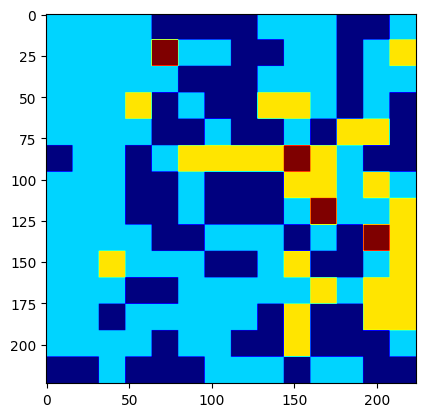

In [285]:
plt.imshow((average_attention*255).astype(int), cmap='jet')

In [297]:
test = ((1-average_attention))
plt.imsave("./test_images/test.png", test, cmap='hot')
image = cv2.imread("./test_images/test.png", 0)
heatmap = cv2.applyColorMap(image, cv2.COLORMAP_HOT)

cv2.imshow('heatmap', heatmap)

: 